 <a id='page-top'></a> <img src='../img/LogoLine_horizon_C3S.png' alt='Logo EU Copernicus ECMWF' align='right' width='100%'></img>

# <a id='page-top'></a> Analysis of Total Column Water Vapour using the COMBI product

This notebook-tutorial provides an introduction to the use of the
combined global near-infrared (NIR) and microwave imager (MWI) total column water vapour (TCWV) data record ([COMBI](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-total-column-water-vapour-land-ocean?tab=overview)) 
for climate studies.

<div style="text-align: justify"> The Water Vapour (WV) Essental Climate Variable (ECV) and of the COMBI TCWV product are described in introduction. Then, a first use case provides an analysis of the time averaged global and seasonal climatological distributions of the total column water vapour as well as the monthly mean climatology. The second use case presents the time series and trend analysis of TCWV. Step-by-step instructions are provided on data preparation, the use cases are extensively documented and each line of code is explained. </div>
<div style="text-align: justify"> The two figures below show some results from both of the use cases and illustrate the successful run of the code. </div>

The notebook comprises the following sections:

## Table of content

* Introduction
* Search, download and view data
* Climatology of the total column water vapour
* Time series and trend analysis of the total column water vapour
* Conclusion

## <a id='intro'></a> Introduction

Anthropogenic activities and natural variations from years to decades shape the Earth's climate. Water vapour has been recognised as an Essential Climate Variable (ECV) as it provides the basis for all cloud formation, cloud physics, and furthermore influences the Earth's heat budget due to its high absorbance of long and short-wave radiation. It is a natural greenhouse gas with a global warming potential much higher than carbon dioxide. An increase in temperature will lead to an increase in water vapour and due to this coupling mechanism to the acceleration of global warming. Total column water vapour (TCWV) is a measure of the integrated water vapour content of the atmosphere.


In the Copernicus Climate Data Store (CDS), the EUMETSAT Satellite Application Facility on Climate Monitoring has brokered the COMBI product which correponnds to the Climate Data Record (CDR-2) developed, generated and validated within the Water Vapour Climate Change Initiative (WV_cci) project proposed by the European Space Agency (ESA). It combines the Special Sensor Microwave - Imager/Sensor (SSMI/S) TCWV retrievals in the microwave spectrum over ocean surfaces with the Medium Resolution Imaging Spectrometer (MERIS) retrievals, the Moderate-resolution Imaging Spectro-radiometer (MODIS) retrievals and the Ocean and Land Colour Imager (OLCI) retrievals in the near-infrared (NIR) over land surfaces. The COMBI product also covers sea-ice and coastal regions, but with a reduced quality.

In this Jupyter notebook tutorial, we present examples, based on monthly mean TCWV products, to illustrate the philosophy on the usage, visualisation, and analysis of the TCWV dataset. Produced images and processed data can be saved to personal devices for later use.

You will find further information about the dataset as well as the data in the Climate Data Store catalogue entry total column water vapour, sections "Overview", "Download data" and "Documentation":
- [Combined global near-infrared (NIR) and microwave imager (MWI) total column water vapour (TCWV) data record (COMBI)](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-total-column-water-vapour-land-ocean?tab=overview)

## <a id='cdsapi'></a> Search, download and view data

<br>
Before we begin, we must prepare our environment. This includes installing the Application Programming Interface (API) of the CDS, and importing the various python libraries that we will need.

### How to access the notebooks


This tutorial is in the form of a [Jupyter notebook](https://jupyter.org/), written in [Python 3.9.4](https://www.python.org/downloads/release/python-394/). You will not need to install any software for the training as there are a number of free cloud-based services to create, edit, run and export Jupyter notebooks such as this. Here are some suggestions (simply click on one of the links below to run the notebook):

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s/main?labpath=Notebook_WVCombi.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-c3s/blob/main/Notebook_WVCombi.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s/blob/main/Notebook_WVCombi.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

The `cdsapi` is used to download the data. This package is not included by default on most cloud platforms yet. You can use `pip` to install it: <br>
```!pip install cdsapi```

### Import libraries

To run this notebook in your own environment, we advise you to install [Anaconda](https://docs.anaconda.com/anaconda/install/), which contains most of the libraries you will need. You will also need to install the [CDS API](https://confluence.ecmwf.int/display/CKB/Climate+Data+Store+%28CDS%29+infrastructure+and+API) (`!pip install cdsapi`) for downloading data programatically from the CDS. It is also recommended to use [Python 3.9.4](https://www.python.org/downloads/release/python-394/) for the purpose of reproducibility and compatibility, with respect to the latest updates of the different libraries.

The data have been stored in files written in NetCDF format. To best handle these, we will import the library [Xarray](http://xarray.pydata.org/en/stable/) which is specifically designed for manipulating multidimensional arrays in the field of geosciences. The libraries Matplotlib and Cartopy will also be imported for plotting and visualising the analysed data. We will also import the libraries [zipfile](https://docs.python.org/3/library/zipfile.html) to work with zip-archives, [OS](https://docs.python.org/3/library/os.html) to use OS-functions and pattern expansion, and [urllib3](https://urllib3.readthedocs.io/en/stable/) for disabling warnings for data download via CDS API.

In [1]:
%matplotlib inline

# Libraries to work with zip-archives, OS functions and pattern expansion
import zipfile
import os
# import glob

# Disable warnings for data download via API
import urllib3
urllib3.disable_warnings()

# CDS API library
import cdsapi

# Libraries for working with multidimensional arrays
import xarray as xr
import numpy as np
import pandas as pd
# Import a sublibrary method for the seasonal decomposition of the time series
from statsmodels.tsa.seasonal import seasonal_decompose

# Libraries for plotting and visualising the data
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)


### Download Data Using CDS API

#### Set up CDS API credentials 

We will request data from the Climate Data Store (CDS): https://cds.climate.copernicus.eu/cdsapp#!/home. If you do not have an account yet, please click on "login/register" at the right top and select "Create new account". Once the registration process is finished, you will be able to login to the CDS and have a look at your favourite data.

We will request data from the CDS programmatically with the help of the [CDS API](https://confluence.ecmwf.int/display/CKB/Climate+Data+Store+%28CDS%29+infrastructure+and+API).
First, we need to manually set the CDS API credentials. 
To do so, we need to define two variables: URL and KEY. 
To obtain these, first login to the CDS, then visit https://cds.climate.copernicus.eu/api-how-to and copy the string of characters listed after "key:". Replace the `#########` below with this string.


In [2]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '######################################'

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [3]:
DATADIR = './'
# Filename for the zip file downloaded from the CDS
download_zip_file = os.path.join(DATADIR, 'combi-tcwv-monthly.zip')
# Filename for the netCDF file which contain the merged contents of the monthly files.
merged_netcdf_file = os.path.join(DATADIR, 'combi-tcwv-monthly.nc')

### Search for data

To search for data, visit the CDS website: https://cds.climate.copernicus.eu/cdsapp#!/home.
Here you can search for COMBI data using the search bar. The data we need for this use case is the combined global near-infrared (NIR) and microwave imager (MWI) total column water vapour (TCWV) data record ([COMBI](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-total-column-water-vapour-land-ocean?tab=overview)).
This catalogue entry provides a combination of the MERIS, MODIS and OLCI retrievals in the near-infrared over land surfaces and coastal areas with the (SSMI/S) TCWV retrievals in the microwave spectrum over ocean surfaces.

After selecting the correct catalogue entry, we will specify the horizontal aggregation and temporal coverage we are interested in.
These can all be selected in the **"Download data"** tab. In this tab a form appears in which we will select the following parameters to download:

- Horizontal aggregation: `0.5`
- Year: `all` (use "Select all" button)
- Month: `all` (use "Select all" button)
- Format: `Compressed zip file (.zip)`

If you have not already done so, you will need to accept the **"terms & conditions"** of the data before you can download it.

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below) ...

### Download data

… Having copied the API request into the cell below, running this will retrieve and download the data you requested into your local directory. However, before you run the cell below, the terms and conditions of this particular dataset need to have been accepted in the CDS. The option to view and accept these conditions is given at the end of the download form, just above the **“Show API request”** option.

In [4]:
c = cdsapi.Client()
c.retrieve(
    'satellite-total-column-water-vapour-land-ocean',
    {
        'horizontal_aggregation': '0_5_x_0_5',
        'year': ['%04d' % (year) for year in range(2003, 2011)],
        'month': ['%02d' % (month) for month in range(1, 13)],
        'variable': 'all',
        'format': 'zip',
    },
    download_zip_file
)

2023-08-21 13:59:59,499 INFO Welcome to the CDS
2023-08-21 13:59:59,500 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-total-column-water-vapour-land-ocean
2023-08-21 13:59:59,760 INFO Request is completed
2023-08-21 13:59:59,761 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data2/dataset-satellite-total-column-water-vapour-land-ocean-ffc3fb6e-5767-4322-ba05-0c49296ace34.zip to ./combi-tcwv-monthly.zip (333M)
2023-08-21 14:00:11,747 INFO Download rate 27.8M/s                                                                                                          


Result(content_length=349153399,content_type=application/zip,location=https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data2/dataset-satellite-total-column-water-vapour-land-ocean-ffc3fb6e-5767-4322-ba05-0c49296ace34.zip)

### Inspect data

The data have been downloaded. We can now unzip the archive and merge all files into one NetCDF file to inspect them. NetCDF is a commonly used format for array-oriented scientifc data. To read and process these data, we will make use of the [Xarray](https://docs.xarray.dev/en/stable/index.html) library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into an [Xarray Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html).

In [5]:
# Unzip the data. The dataset is split in monthly files.
with zipfile.ZipFile(download_zip_file, 'r') as zip_ref:
    filelist = [os.path.join(DATADIR, f) for f in zip_ref.namelist()]
    zip_ref.extractall(DATADIR)
# Ensure the filelist is in the correct order
filelist = sorted(filelist)

# Merge all unpacked files into one.
ds = xr.open_mfdataset(filelist)
ds.to_netcdf(merged_netcdf_file)

# Recursively delete unpacked data
for f in filelist:
    os.remove(f)

# Read data
ds_combi = xr.open_dataset(merged_netcdf_file, decode_times=True, mask_and_scale=True)

Now we can query our newly created Xarray...

In [6]:
ds_combi

<xarray.Dataset>
Dimensions:         (time: 96, lon: 720, lat: 360)
Coordinates:
  * time            (time) datetime64[ns] 2003-01-15 2003-02-15 ... 2010-12-15
  * lon             (lon) float64 -180.0 -179.5 -179.0 ... 179.0 179.5 180.0
  * lat             (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
Data variables:
    n_obs           (time, lat, lon) float32 ...
    valid_fraction  (time, lat, lon) float32 ...
    cloud_fraction  (time, lat, lon) float32 ...
    tcwv            (time, lat, lon) float32 ...
    tcwv_err        (time, lat, lon) float32 ...
    tcwv_stdev      (time, lat, lon) float32 ...
    tcwv_back       (time, lat, lon) float32 ...
    l3_flags        (time, lat, lon) int64 ...
Attributes: (12/21)
    product_version:      1.0
    creator_name:         DE/DWD & FUB
    creator_email:        jan.elkassar@wew.fu-berlin.de
    project:              Copernicus Climate Change Services (C3S)
    institution:          Freie Universität Berlin
    date_created:         ['2019-08-23 02:49:54', '024954']
    ...                   ...
    instrument:           SSM/I > Special Sensor Microwave/Imager, MERIS > Me...
    platform:             DMSP 5D-2/F13 > Defense Meteorological Satellite Pr...
    summary:              This dataset contains Thematic Climate Data Records...
    metainfo:             MERIS TCWV is processed with an updated and calibra...
    history:              Fri Feb 19 13:10:36 2021: ncatted -a calendar,time,...
    NCO:                  netCDF Operators version 4.7.8 (Homepage = http://n...

We see that the dataset has nine variables among which **"tcwv"**, which stands for "total column water vapour", and three dimension coordinates of **lon**, **lat** and **time**.

While an Xarray **dataset** may contain multiple variables, an Xarray **data array** holds a single multi-dimensional variable and its coordinates. To make the processing of the **tcwv** data easier, we convert it into an Xarray data array. 

In [7]:
da_tcwv = ds_combi['tcwv']

Let us view these data:

In [8]:
da_tcwv

<xarray.DataArray 'tcwv' (time: 96, lat: 360, lon: 720)>
[24883200 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2003-01-15 2003-02-15 ... 2010-12-15
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 179.0 179.5 180.0
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
Attributes:
    long_name:      1D-Var Total Column Water Vapor from MERIS and SSM/I
    units:          kg/m^2
    fill_value:     -32767.0
    standard_name:  atmosphere_mass_content_of_water_vapor

### Plot data

We can visualize one time step to figure out what the data look like. Xarray offers built-in matplotlib functions that allow you to plot a `DataArray`. With the function `plot()`, you can easily plot e.g. the first time step of the loaded array.

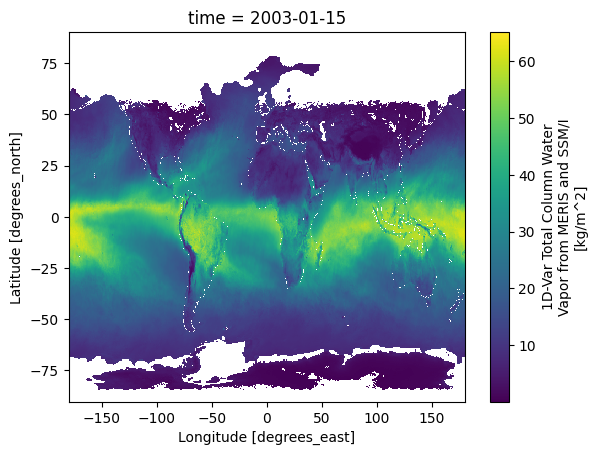

In [9]:
da_tcwv[0, :, :].plot()

An alternative to the built-in Xarray plotting functions is to make use of a combination of the plotting libraries [matplotlib](https://matplotlib.org/) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/). One of Cartopy’s key features is its ability to transform array data into different geographic projections. In combination with matplotlib, it is a very powerful way to create high-quality visualisations and animations. In later plots, we will make use of these libraries to produce more customised visualisations.

## <a id='climatology'></a> Climatology of the total column water vapour

<br>
<div style="text-align: justify"> In this section we will analyse the time averaged global and seasonal climatological distributions of the total column water vapour as well as the monthly mean climatology. </div>

### Time averaged global climatological distribution of TCWV

To calculate the mean climatology of total column water vapour for the time period January 2006 to December 2011, we have to select the specific time range using the Xarray method `sel` that indexes the data and dimensions by the appropriate indexers.
We can then use the method `mean` to calculate the mean along the time dimension. 

In [10]:
# Select the tcwv data for the whole time period
tcwv = da_tcwv.sel(time=slice('2003-01-01', '2010-12-31'))

# Calculate the mean along the time dimension
tcwv_mean = tcwv.mean(dim='time')

We can now visualize the global mean climatological distribution of the total column water vapour for the period January 2006 - December 2011. This time we will make use of a combination of the plotting libraries [Matplotlib](https://matplotlib.org/stable/index.html) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) to create a more customised figure. 

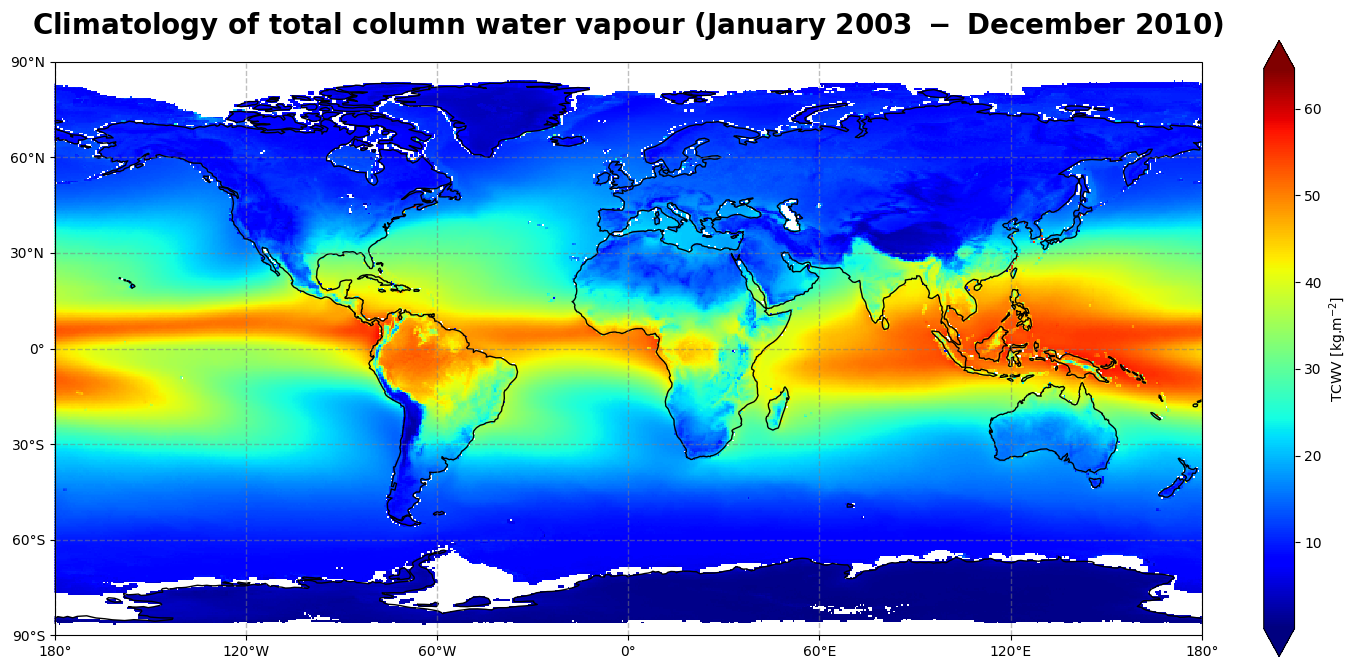

In [11]:
# Create the figure panel and the map using the Cartopy PlateCarree projection
fig1, ax1 = plt.subplots(1, 1, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
im = plt.pcolormesh(tcwv_mean.lon, tcwv_mean.lat, tcwv_mean, cmap='jet')

# Set the figure title, add lat/lon grid and coastlines
ax1.set_title(
    '$\\bf{Climatology\ of\ total\ column\ water\ vapour\ (January\ 2003\ -\ December\ 2010)}$',
    fontsize=20,
    pad=20)
# Add coastlines
ax1.coastlines(color='black')
# Define gridlines and ticks
ax1.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
# Gridlines
gl = ax1.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Specify the colorbar
cbar = plt.colorbar(im, fraction=0.025, pad=0.05, extend='both')
cbar.set_label('TCWV [kg.m$^{-2}$]')

# Save the figure
fig1.savefig(f'{DATADIR}combi_tcwv_climatology.png')

**Figure 1** shows the global climatology of the total column water vapour for the time period of January 2006 - December 2011 over ocean and land, sea ice and coastal regions.

The total column water vapour has a dominant structure along the equator and over water masses where most of the evaporation takes place, i.e. mainly in the tropics. Solar irradiance and its relative position on the Earth's surface (solar zenith angle) controls evaporation, leading to the transition of water from the liquid phase to the gaseous phase, which is subsequently advected to higher altitudes. This is the main driver of the Inter-Tropical Convergence Zone (ITCZ) along the equator, visible as a band of high amount of total column water vapour from the East Pacific to the West Pacific over Central America and Brazil, the Atlantic Ocean, Africa and the Indian Ocean.

### Time averaged seasonal climatological distribution of TCWV

The TCWV data can also be splitted according to the seasons by using the `groupby()` method, with `'time.season'` as an argument, and then averaged over the years. 
Seasons are defined as follows:
- Spring: March, April, May
- Summer: June, July, August
- Autumn: September, October, November
- Winter: December, January, February

In [12]:
# Split data array tcwv by season
tcwv_seasonal_climatology = tcwv.groupby('time.season').mean('time')
tcwv_seasonal_climatology

<xarray.DataArray 'tcwv' (season: 4, lat: 360, lon: 720)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 179.0 179.5 180.0
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

The xarray "tcwv_seasonal_climatology" has four entries in the time dimension (one for each season). The `nan` values correspond to the extreme latitudes (see lat coordinates) of the polar regions where no measurements have been made (cf. **Figure 1**). The climatology of the total column water vapour distribution can now be plotted for each season.

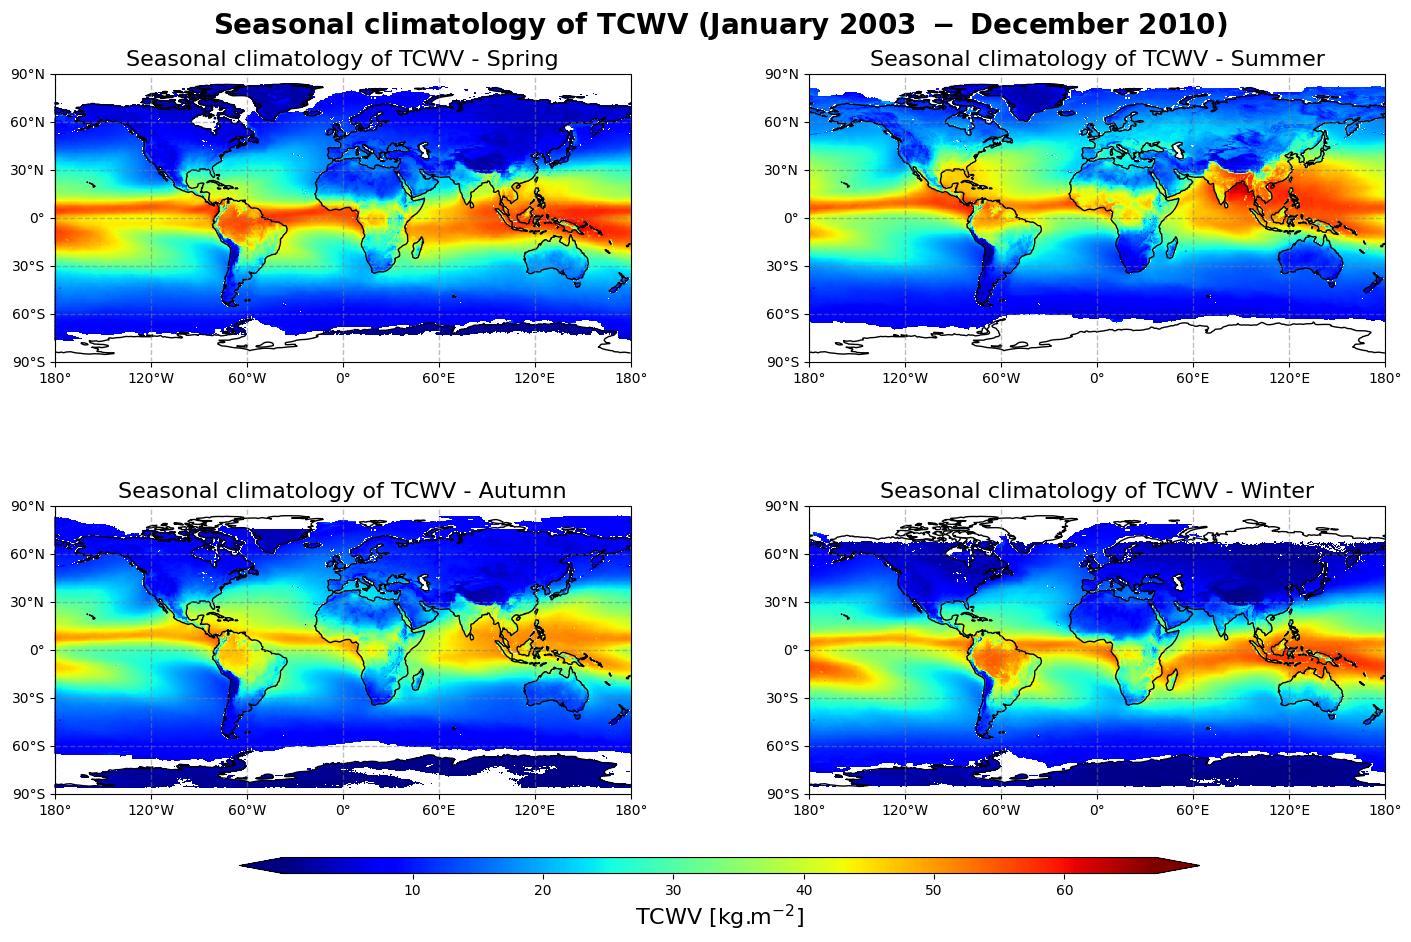

In [13]:
# Create a list of the seasons such as defined in the dataset tcwv_seasonal_climatology:
seasons = ['MAM', 'JJA', 'SON', 'DJF']

# We use the "subplots" to place multiple plots according to our needs. 
# In this case, we want 4 plots in a 2x2 format.
# For this "nrows" = 2 and "ncols" = 2, the projection and size are defined as well
fig2, ax2 = plt.subplots(nrows=2,
                         ncols=2,
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         figsize=(16,8))

# Define a dictionary of subtitles, each one corresponding to a season
subtitles = {'MAM': 'Spring', 'JJA': 'Summer', 'SON': 'Autumn', 'DJF': 'Winter'}

# Configure the axes and subplot titles
for i_season, c_season in enumerate(seasons):
    # convert i_season index into (row, col) index
    row = i_season // 2
    col = i_season % 2
    # Plot data (coordinates and data) and define colormap
    im = ax2[row][col].pcolormesh(tcwv_seasonal_climatology.lon,
                                  tcwv_seasonal_climatology.lat,
                                  tcwv_seasonal_climatology.sel(season=c_season),
                                  cmap='jet')
    # Set title and size
    ax2[row][col].set_title('Seasonal climatology of TCWV - ' + subtitles[c_season], fontsize=16)
    # Add coastlines
    ax2[row][col].coastlines()
    # Define grid lines and ticks (e.g. from -180 to 180 in an interval of 60)
    ax2[row][col].set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
    ax2[row][col].set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax2[row][col].xaxis.set_major_formatter(lon_formatter)
    ax2[row][col].yaxis.set_major_formatter(lat_formatter)
    # Gridline
    gl = ax2[row][col].gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Place the subplots
fig2.subplots_adjust(bottom=0.0, top=0.9, left=0.05, right=0.95, wspace=0.1, hspace=0.5)

# Define and place a colorbar at the bottom
cbar_ax = fig2.add_axes([0.2, -0.1, 0.6, 0.02])
cbar = fig2.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('TCWV [kg.m$^{-2}$]', fontsize=16)

# Define an overall title
fig2.suptitle('$\\bf{Seasonal\ climatology\ of\ TCWV\ (January\ 2003\ -\ December\ 2010)}$',
              fontsize=20)

# Save the figure
fig2.savefig(f'{DATADIR}combi_tcwv_seasonal_climatology.png')

**Figure 2** shows the seasonal mean climatology of the total column water vapour from Spring to Winter (top left to bottom right panels) derived from the combined measurements of MERIS, MODIS, OLCI and SSMI/S.

The general pattern is overall the same as in **Figure 1** with higher values in the tropics and lower values in the extra tropics. The band of high amount of TCWV (particularly noticeable between South-East Asia and North Australia) oscillates around the equator, reaching its highest values in the Summer Hemisphere, which confirms the dominant influence of the solar radiation over the course of the inter-tropical convergence zone.

### Zonally averaged montly mean climatology of TCWV

We will now calculate the monthly mean climatology of the total column water vapour over the time period January 2006 - December 2011 by first applying the `groupby()` method to group the data array by month and then calculating the average for each monthly group. The resulting data array is the monthly climatology for the total column water vapour based on reference January 2006 - December 2011. 

In [14]:
tcwv_clim_month = tcwv.groupby('time.month').mean("time")
tcwv_clim_month

<xarray.DataArray 'tcwv' (month: 12, lat: 360, lon: 720)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 179.0 179.5 180.0
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

Let us view the zonal monthly climatology of the TCWV. To do this, we will average across the longitude bands with the `mean()` method, align the time dimension coordinate with the x axis and the lat dimension coordinate along the y axis using the method `transpose()`...

In [15]:
tcwv_zonal_clim_month = tcwv_clim_month.mean(dim="lon").transpose()
tcwv_zonal_clim_month

<xarray.DataArray 'tcwv' (lat: 360, month: 12)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

Now we can plot our data. Before we do this however, we define the min, max and step of contours that we will use in a contour plot.

In [16]:
vdiv = 1
vmin = 0
vmax = 50
clevs = np.arange(vmin, vmax, vdiv)

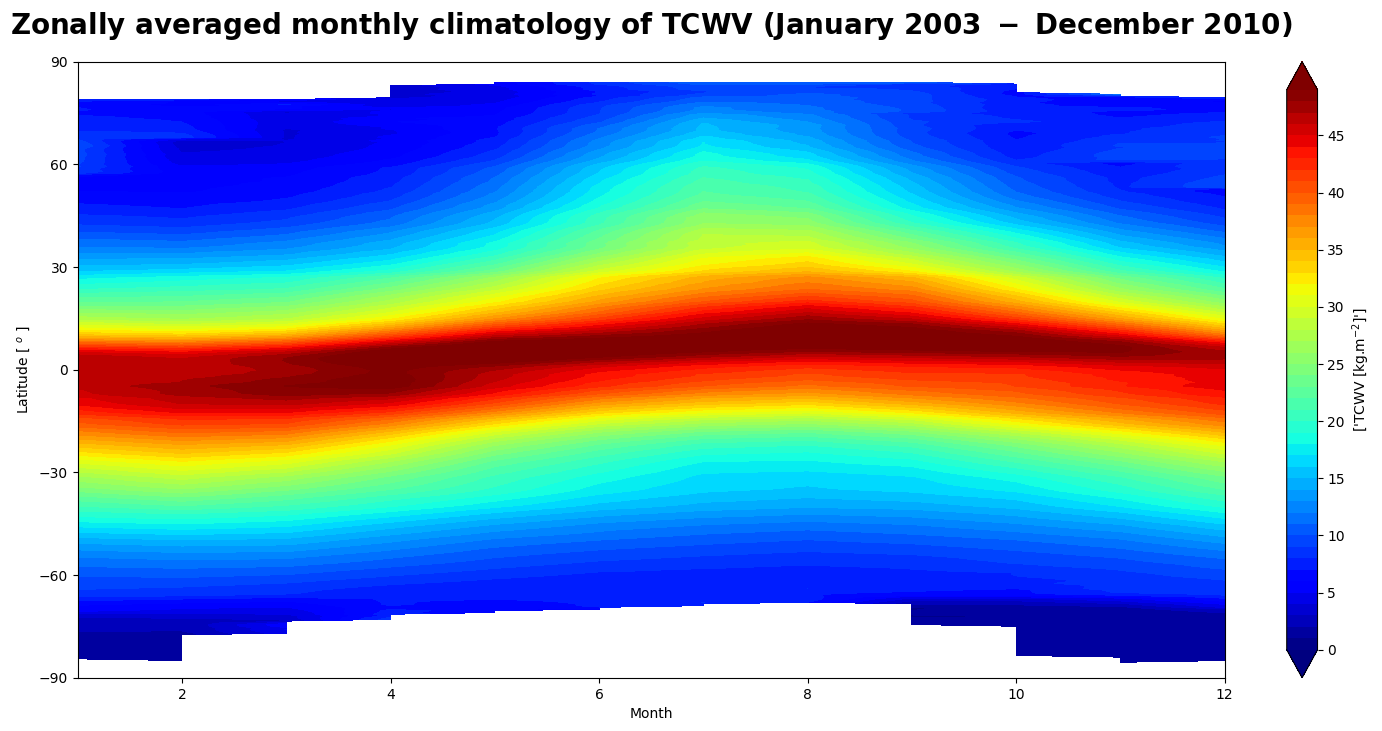

In [17]:
# Define the figure and specify size
fig3, ax3 = plt.subplots(1, 1, figsize=(16, 8))

# Configure the axes and figure title
ax3.set_xlabel('Month')
ax3.set_ylabel('Latitude [ $^o$ ]')
ax3.set_yticks(np.arange(-90, 91, 30))
ax3.set_title(
    '$\\bf{Zonally\ averaged\ monthly\ climatology\ of\ TCWV\ (January\ 2003\ -\ December\ 2010)}$',
    fontsize=20,
    pad=20)

# As the months (12) are much less than the latitudes (180),
# we need to ensure the plot fits into the size of the figure.
ax3.set_aspect('auto')

# Plot the data as a contour plot
contour = ax3.contourf(tcwv_zonal_clim_month.month,
                       tcwv_zonal_clim_month.lat,
                       tcwv_zonal_clim_month,
                       levels=clevs,
                       cmap='jet',
                       extend='both')

# Specify the colorbar
cbar = plt.colorbar(contour, fraction=0.025, pad=0.05)
cbar.set_label(['TCWV [kg.m$^{-2}$]'])

# Save the figure
fig3.savefig(f'{DATADIR}combi_tcwv_monthly_climatology.png')

**Figure 3** shows the seasonal motion of the water vapour band crossing the equator from boreal Summer (July) to austral Summer (December) associated with the Inter-Tropical Convergence Zone.

In the next use case, we will anlyse the temporal evolution of the total column water vapour and its annual seasonal variation.

## <a id='timeseries'></a> Time series and trend analysis of the total column water vapour

<br>
<div style='text-align: justify'> After looking at the time averaged global distribution of the total column water vapour, we further investigate the dataset. The COMBI product spans over 15 years of satellite observations, and another useful way of analysing and visualizing the temporal evolution of total column water vapour is using the time series. We will calculate global time series, plot it, and discuss most imprortant features. </div>

### Global time series of TCWV

We first create a temporal subset for the period January 2006 to December 2011.

In [18]:
# Select time period
tcwv_combi = da_tcwv.sel(time=slice('2003-01-01', '2010-12-31'))
tcwv_combi

<xarray.DataArray 'tcwv' (time: 96, lat: 360, lon: 720)>
[24883200 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2003-01-15 2003-02-15 ... 2010-12-15
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 179.0 179.5 180.0
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
Attributes:
    long_name:      1D-Var Total Column Water Vapor from MERIS and SSM/I
    units:          kg/m^2
    fill_value:     -32767.0
    standard_name:  atmosphere_mass_content_of_water_vapor

#### Spatial aggregation

<br>
<div style="text-align: justify"> We would like to visualise these data, not in maps but as one dimensional time series of global average values. To do this, we will first need to aggregate the data spatially to create a single global average at each time step. In order to aggregate over the latitudinal dimension, we need to take into account the variation in area as a function of latitude. We will do this by using the cosine of the latitude as a proxy: </div>

In [19]:
weights = np.cos(np.deg2rad(tcwv_combi.lat))
weights.name = "weights"
tcwv_combi_weighted = tcwv_combi.weighted(weights)

The next step is to compute the mean across the latitude and longitude dimensions of the weighted data array with the `mean()` method.

In [20]:
tcwv_weighted_mean = tcwv_combi_weighted.mean(dim=("lat", "lon"))

#### Plot data

Now we can plot the time series of globally averaged TCWV data over time using the `plot()` method.<br>

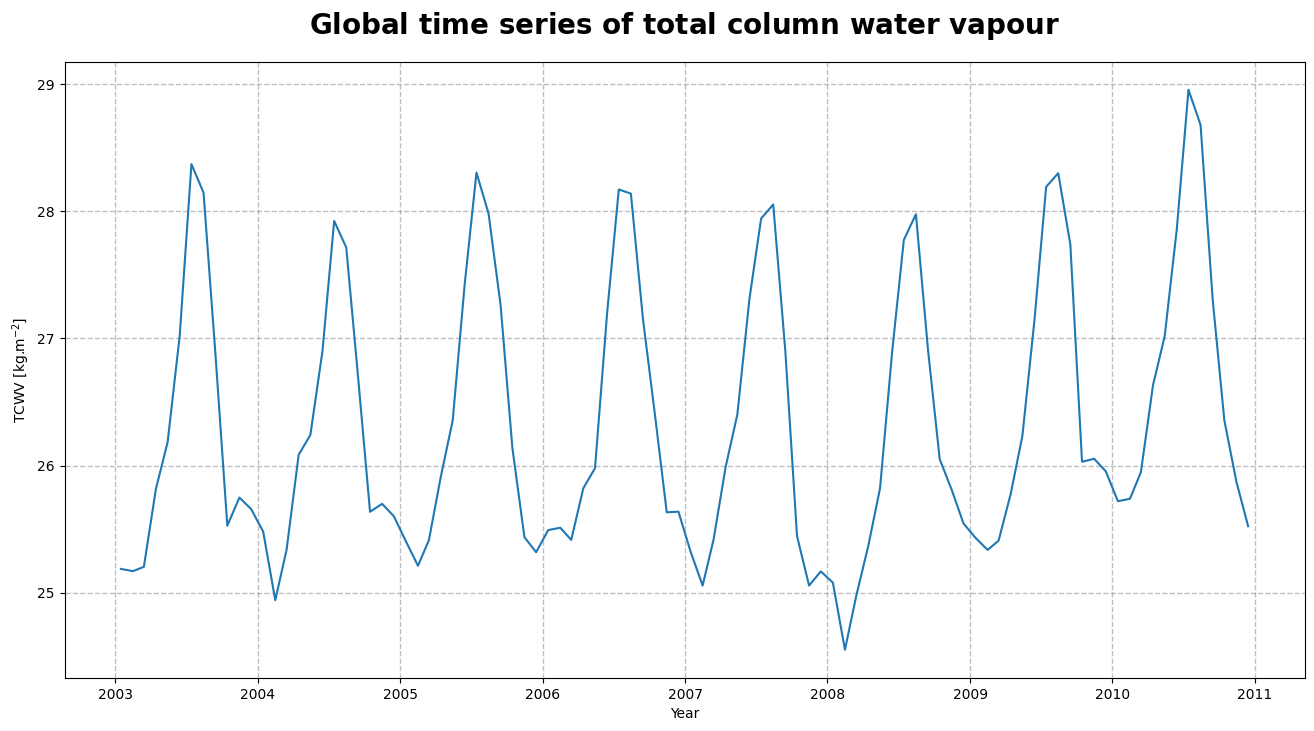

In [21]:
# Define the figure and specify size
fig4, ax4 = plt.subplots(1, 1, figsize=(16, 8))

# Configure the axes and figure title
ax4.set_xlabel('Year')
ax4.set_ylabel('TCWV [kg.m$^{-2}$]')
ax4.grid(linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax4.set_title('$\\bf{Global\ time\ series\ of\ total\ column\ water\ vapour}$', fontsize=20, pad=20)

# Plot the data
ax4.plot(tcwv_weighted_mean.time, tcwv_weighted_mean)

# Save the figure
fig4.savefig(f'{DATADIR}combi_tcwv_global_timeseries.png')

**The Figure 4**, shows the time series of the monthly mean total column water vapour. From the time series, we can infer the seasonal pattern along with a trend in the global space and time averaged TCWV.

Since COMBI is a stable and robust product wchich has been validated with other data, this trend can be assumed to be a real climatological increase in water vapour.

We can now calculate the monthly climatology of the total column water vapour for the period January 2003 to December 2017 to study more specifically the amplitude and the evolution of the seasonal cycle over the years.

### <a id='season'></a> Monthly climatology of TCWV

To compute the monthly climatology of the total column water vapour, we will apply the `groupby()` method to the Xarray Data Array `tcwv_weighted_mean` which we have defined in the previous section before computing the mean and the associated standard deviation using the `mean()` and `std()` methods respectively.

In [22]:
# Monthly climatology
# Compute the global monthly mean climatology of tcwv
tcwv_clim_month_mean = tcwv_weighted_mean.groupby('time.month').mean()
# Compute the associated standard deviation
tcwv_clim_month_std = tcwv_weighted_mean.groupby('time.month').std()

To have a first idea of the evolution of TCWV over the years, we can also create an Xarray data array with year and month as dimension coordinates to determine for which year was the "driest" (lowest seasonal envelope) and which one was the "wettest" (highest).

In [23]:
# Creation of a new Xarray Data Array to determine the "driest" and "wettest" years
# Creation of a n_years x n_months climatological array
tcwv_clim = tcwv_weighted_mean.data.reshape(-1, 12)
# Initialization of the corresponding Xarray Data Array
year = ['%04d' % (year) for year in range(2003, 2011)]
month = ['%02d' % (month) for month in range(1, 13)]
da_tcwv_clim = xr.DataArray(data=tcwv_clim,
                            dims=["year", "month"],
                            coords=dict(year=year,
                                        month=month),
                            name='tcwv_clim')
# Determine the years with highest and lowest seasonal values of TCWV
# Year of minimum TCWV values in average
tcwv_clim_min = da_tcwv_clim.mean(dim='month').min()
year_tcwv_clim_min = da_tcwv_clim.mean(dim='month').data.argmin()
year_min_tcwv = year[year_tcwv_clim_min]
# Year of maximum TCWV values in average
tcwv_clim_max = da_tcwv_clim.mean(dim='month').max()
year_tcwv_clim_max = da_tcwv_clim.mean(dim='month').data.argmax()
year_max_tcwv = year[year_tcwv_clim_max]
# Compute (and show) the mean difference between the "wettest" and "driest" year in average
peak_to_peak_tcwv_clim = tcwv_clim_max - tcwv_clim_min
peak_to_peak_tcwv_clim.data

array(0.73829413)

We will now plot the global monthly climatology over the years.

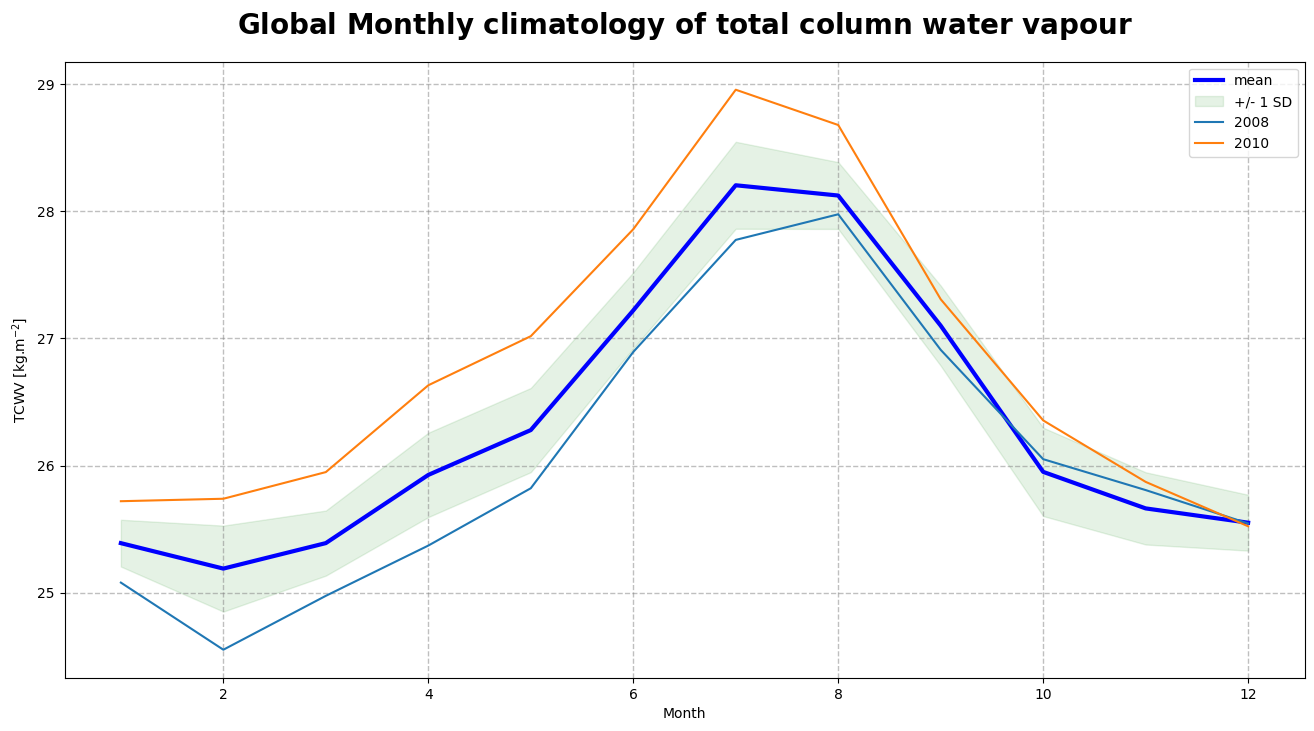

In [24]:
# Define the figure and specify size
fig5, ax5 = plt.subplots(1, 1, figsize=(16, 8))

# Plot the data
ax5.plot(tcwv_clim_month_mean.month, tcwv_clim_month_mean, color='blue', linewidth=3, label='mean')
ax5.fill_between(tcwv_clim_month_mean.month,
                 (tcwv_clim_month_mean - tcwv_clim_month_std),
                 (tcwv_clim_month_mean + tcwv_clim_month_std),
                 alpha=0.1,
                 color='green',
                 label='+/- 1 SD')
for year in [year_min_tcwv, year_max_tcwv]:
    ax5.plot(tcwv_clim_month_mean.month,
             da_tcwv_clim.sel(year=year),
             label=year)

# Configure the axes and figure title
ax5.set_title('$\\bf{Global\ Monthly\ climatology\ of\ total\ column\ water\ vapour}$',
              fontsize=20,
              pad=20)
ax5.set_ylabel('TCWV [kg.m$^{-2}$]')
ax5.set_xlabel('Month')
handles, labels = ax5.get_legend_handles_labels()
ax5.legend(handles, labels)
ax5.grid(linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Save the figure
fig5.savefig(f'{DATADIR}combi_tcwv_global_monthly_climatology.png')

**Figure 5** shows the monthly climatology of the total column water vapour represented by the mean and standard deviation (or spread) over the time period January 2006 - December 2011.

We observe a seasonal variation of TCWV with an amplitude of 2-2.5 kg/m$^{2}$, reaching its highest values around July-August and its lowest values around December-January. From the mean difference of 0.738 kg/m$^{2}$ between the highest seasonal envelope corresponding to the year 2010 and the lowest seasonal envelope corresponding to the year 2008, we can assume an increase in the amount of TCWV over the years, which will now be studied in more details by the seasonal decomposition of the total column water vapour.

### Trend analysis and seasonal cycle of TCWV

<br>
The time series can be further analysed by extracting the trend, or the running annual mean, and the seasonal cycle.

To this end, we will convert the Xarray Data Array into a time series with the [pandas](https://pandas.pydata.org/) library before decomposing it into the trend, the seasonal cycle and the residuals by using the `seasonal_decompose()` method and visualizing the results.

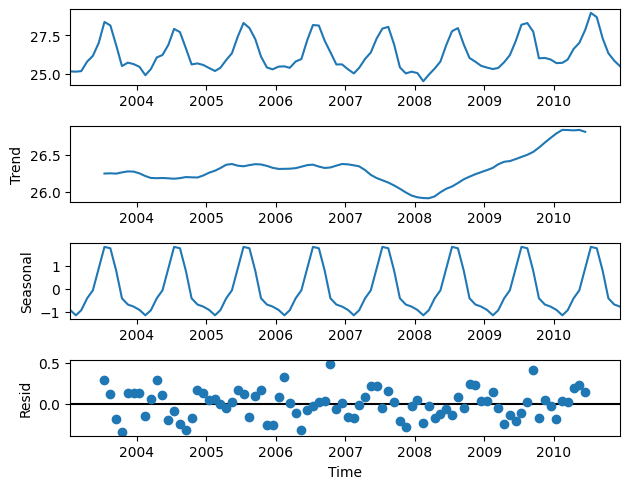

In [25]:
# Convert the Xarray data array tcwv_weighted_mean into a time series
tcwv_weighted_mean_series = pd.Series(tcwv_weighted_mean)
# Define the time dimension of tcwv_weighted_mean as the index of the time series
tcwv_weighted_mean_series.index = tcwv_weighted_mean.time.to_dataframe().index

# Decomposition of the time series into the trend, the seasonal cycle and the residuals
tcwv_seasonal_decomposition = seasonal_decompose(tcwv_weighted_mean_series,
                                                 model='additive',
                                                 period=12)

# Plot the resulting seasonal decomposition
tcwv_seasonal_decomposition.plot()
plt.xlabel("Time")
plt.savefig(f'{DATADIR}combi_tcwv_timeseries_climatology.png')

**Figure 6** shows the decomposition of the TCWV time series into the trend (2nd panel) and the seasonal cycle with a confirmed amplitude of 2-2.5 kg/m$^{2}$ (3rd panel), from which are derived the anomalies or de-trended and de-seasonalised time series that have the characteristics of uncorrelated noise pattern (4th panel).

The anomaly index can be attributed to some exceptional time periods and can be used to calculate the autocorrelation for a given time lag, in order to derive the "memory effect" and its length, in the global water vapour system. The trend analysis presents two peaks around the years 1998 and 2010, which can be related respectively to a strong “El Niño” event in 1997/1998 and a moderate one in 2010. In addition, a positive trend can be observed from the year 2010 onwards. The combination of strong “El Niño” events and higher overall trends might lead to extreme values in the total column water vapour in the future.

<br>

## <a id='conclusion'></a> Conclusion

<br>
<div style='text-align: justify'> In this notebook we have provided some use cases, based on the combined global near-infrared (NIR) and microwave imager (MWI) total column water vapour (TCWV) data record to illustrate the way this dataset can be used to study, analyse and visualise this essential climate variable. The current dataset indicates a clear increase of total column water vapour between January 2003 and December 2017. Comparisons with other independent datasets can be made to further investigate the trends that can be attributed to global climate change, El-Niño events, and external solar cycle forcing. </div>